In [1]:
# all imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import geopandas as gpd
import pandas as pd
import urllib.request as url
import json
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
from scipy.signal import savgol_filter
#import statsmodels.api as sm

In [2]:
### SETUP VARIABLES ###
curedays = 28 # ESTIMATE of days infected are treated as cured (median)
top = 10 # top X countries for bar chart comparison
days = 31 # time frame for last X days of infections data visualization

# also possible to change d and h in Frame 11 (see description)

gradient has 73 colors:


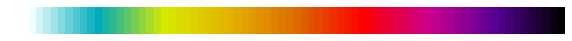

In [3]:
# this is (optional) to generate a custom gradient (interpolate n colors)
# https://stackoverflow.com/questions/25668828/how-to-create-colour-gradient-in-python

#fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
def colorFader(c1,c2,mix=0): 
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

colors1 = ['#FFFFFF', '#51FFEA', '#00DC26', '#FFD000', '#EE003E', '#76006F']
colors = ['#EEFFFF','#00ABBB','#D8EA00','#E3B100','#DB6A00','#FF0000','#CB008F','#580096','#000000']

# interpolates add aditional colors in between colors of colors array
def interpolateColorGradient(colors, add):
    palette = [colors[0]]
    for c in range(len(colors)-1):
        for x in range(1,int(add+1)+1):
            palette += [colorFader(colors[c],colors[c+1],x/(add+1))]
    return palette

palette = []
palette = interpolateColorGradient(colors, 8)
print("gradient has", len(palette), "colors:")
fig, ax = plt.subplots(figsize=(10, 0.5))
for x in range(len(palette)):
    ax.axvline(x, color=palette[x], linewidth= 600 / len(palette)) 
plt.axis("off")
plt.show()
#print(palette)

In [4]:
# run this line to update the covid data file
url.urlretrieve('https://covid.ourworldindata.org/data/ecdc/full_data.csv', 'data/covid19.csv')

('data/covid19.csv', <http.client.HTTPMessage at 0x24a49036c48>)

In [5]:
# setup data
world = gpd.read_file('data/110m_countries.shp')[['ADMIN', 'ADM0_A3', 'geometry', 'POP_EST', 'GDP_MD_EST']]
world = world.drop(world.index[159]) # remove Antarctica
world.columns = ['country', 'code', 'geometry', 'population', 'gdp'] # rename columns
world['country'] = world['country'].replace({'United States of America' : 'United States', 'Czechia' : 'Czech Republic', 'Republic of Serbia' : 'Serbia'})
cdata = pd.read_csv('data/covid19.csv').fillna(0)

In [6]:
# calculate cured numbers (or dead)
# formula = total infected above 4 weeks ago minus dead
# calculate total currently infected
# formula = total - cured - dead

tmp = cdata.shift(curedays)
t2 = cdata.copy()
t2['cured'] = (tmp.total_cases[cdata.location == tmp.location] - tmp.total_deaths).fillna(0)
t2['currently_infected'] = t2.total_cases - t2.cured - t2.total_deaths
cdata = t2

In [7]:
# merge common data
date_start = min(cdata['date'])
date_end = max(cdata['date'])
dates = pd.date_range(date_start, date_end)

def json_data(selectedYear):
    yr = cdata[cdata['date'] == selectedYear]
    merged = world.merge(yr, left_on = 'country', right_on = 'location', how = 'left')
    merged['percent_infected'] = (merged.total_cases / merged.population * 100).map('{:.2f}%'.format)
    merged.fillna('No data', inplace = True)
    #merged.head
    merged_json = json.dumps(json.loads(merged.to_json()))
    return merged_json

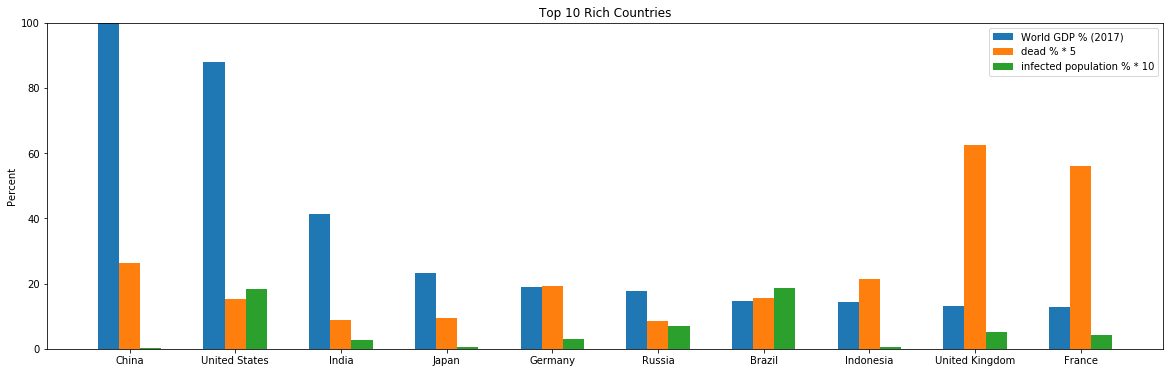

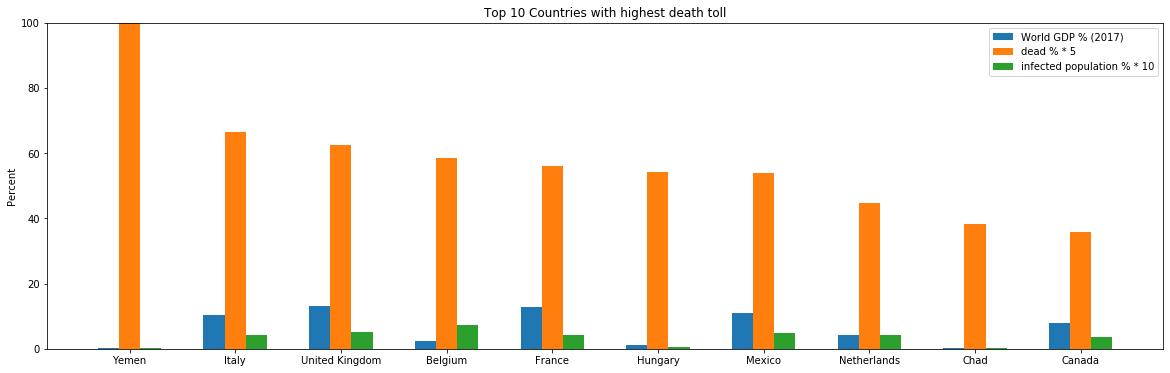

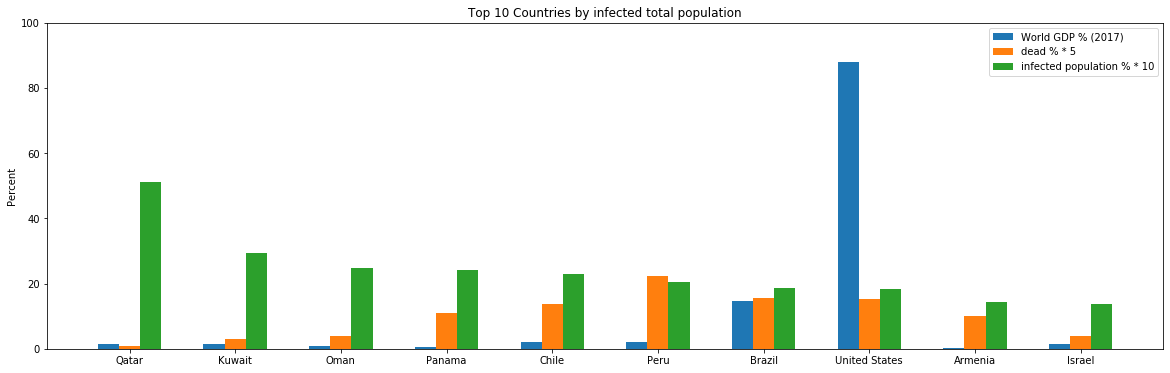

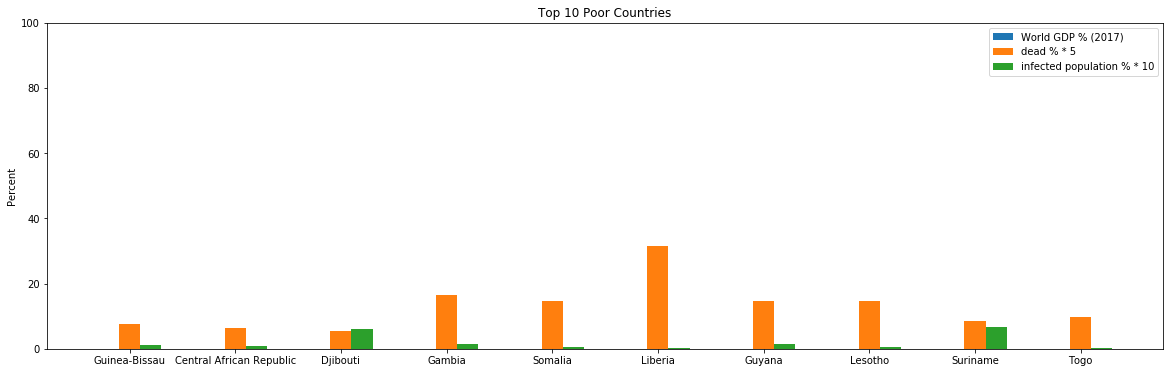

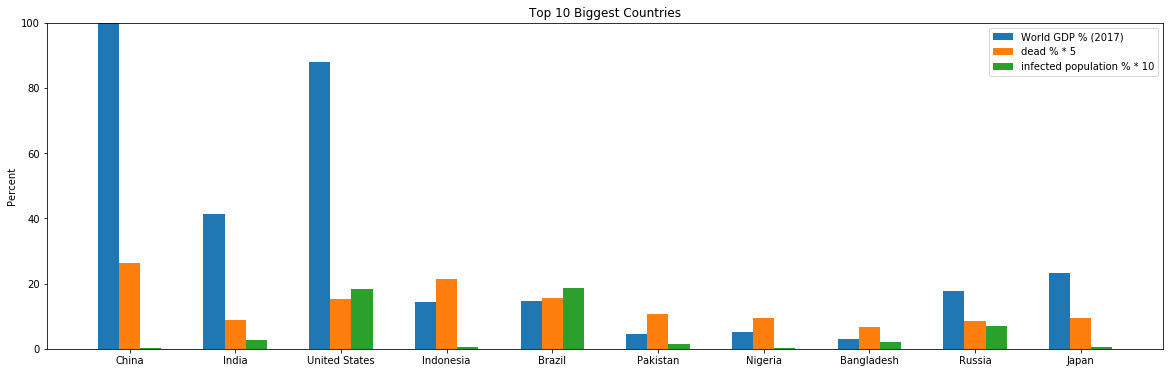

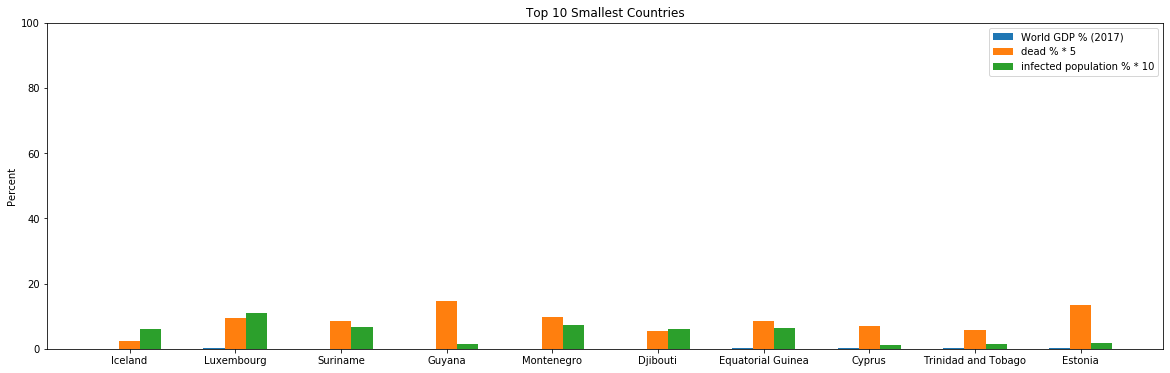

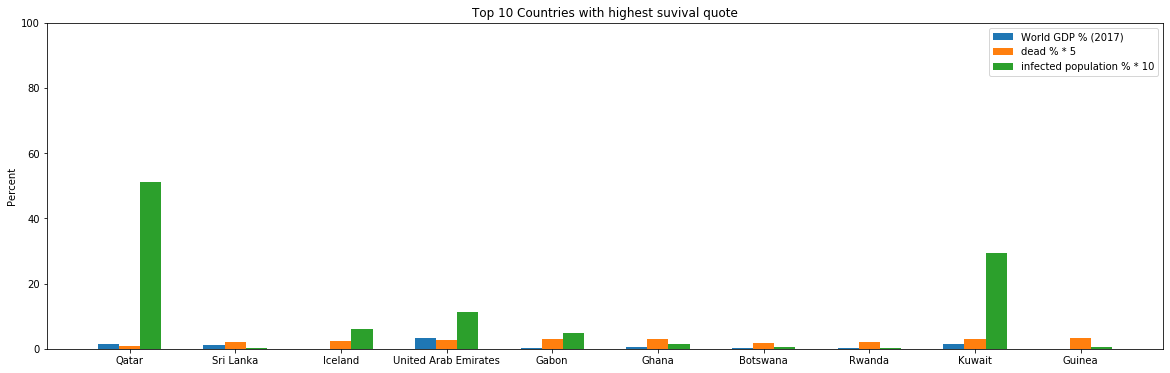

In [8]:
mrgd = world.merge(cdata,left_on = 'country', right_on = 'location', how = 'left').dropna()#.fillna('No data', inplace = True)
mrgd['percent_infected'] = (mrgd.total_cases / mrgd.population * 100).round(2)#.map('{:.2f}%'.format)
mrgd['percent_dead'] = (mrgd.total_deaths / mrgd.total_cases * 100).round(2)#.map('{:.2f}%'.format)
mrgd['percent_gdp'] = (mrgd.gdp / max(mrgd['gdp']) * 100).round(2)
mrgd['percent_countrysize'] = (mrgd.population / max(mrgd['population']) * 100).round(2)
mrgd['quotient_survival'] = (mrgd.cured / mrgd.total_deaths).round(2)

# compare some countrys
dta = mrgd[mrgd.date == date_end].drop(columns=['geometry'])
dta = dta[dta['total_cases'] > 1000]
percent = dta.sort_values(by=['percent_infected'], ascending = False)[:top].reset_index()
dead = dta.sort_values(by=['percent_dead'], ascending = False)[:top].reset_index()
topgdp = dta.sort_values(by=['percent_gdp'], ascending = False)[:top].reset_index()
bottomgdp = dta.sort_values(by=['percent_gdp'], ascending = True)[:top].reset_index()
biggest = dta.sort_values(by=['percent_countrysize'], ascending = False)[:top].reset_index()
smallest = dta.sort_values(by=['percent_countrysize'], ascending = True)[:top].reset_index()
survivability = dta.sort_values(by=['quotient_survival'], ascending = False)[:top].reset_index()


def printBars(topdata=topgdp, lbl='Rich Countries', width=0.2):
    x = np.arange(top)

    fig, ax = plt.subplots(figsize=(20,6))
    #ax.set_yscale('log')
    ax.bar(x - width, topdata['percent_gdp'], width, label='World GDP % (2017)')
    ax.bar(x, topdata['percent_dead'] * 5, width, label='dead % * 5')
    ax.bar(x + width, topdata['percent_infected'] * 10, width, label='infected population % * 10')

    ax.set_ylabel('Percent')
    ax.set_title('Top ' + str(top) + ' ' + lbl)
    ax.set_xticks(x)
    ax.set_xticklabels(topdata['country'])
    ax.set_ylim([0,100])
    ax.legend()

printBars(topgdp, 'Rich Countries')
printBars(dead, 'Countries with highest death toll')
printBars(percent, 'Countries by infected total population')
printBars(bottomgdp, 'Poor Countries')
printBars(biggest, 'Biggest Countries')
printBars(smallest, 'Smallest Countries')
printBars(survivability, 'Countries with highest suvival quote')

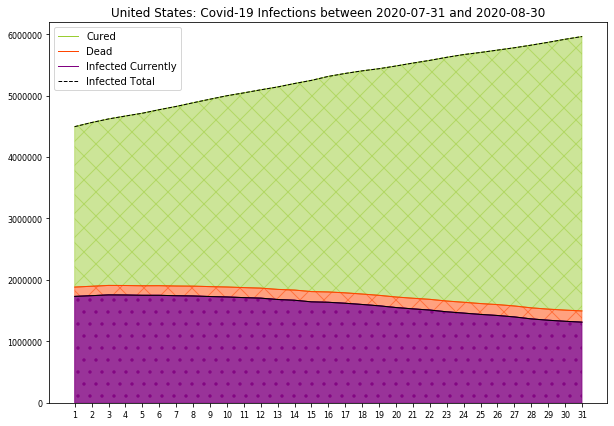

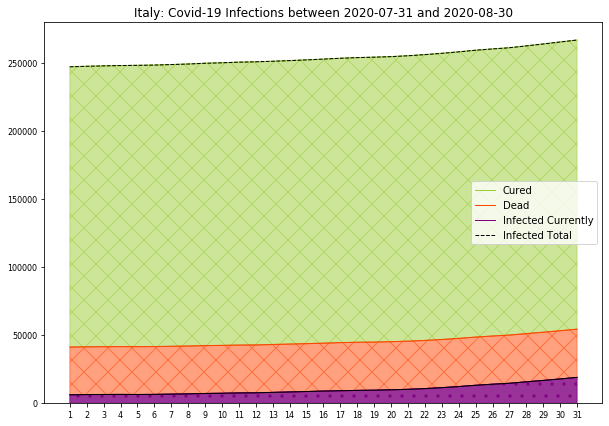

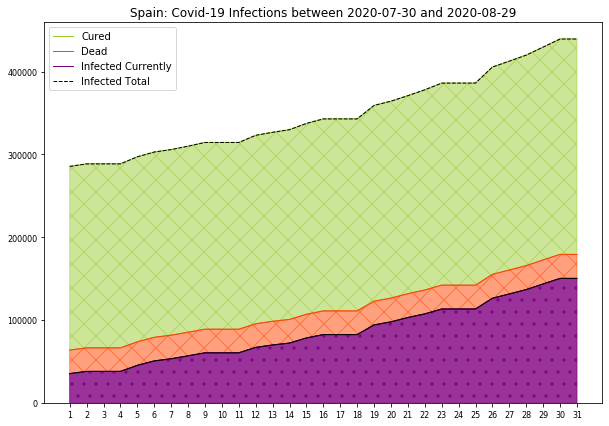

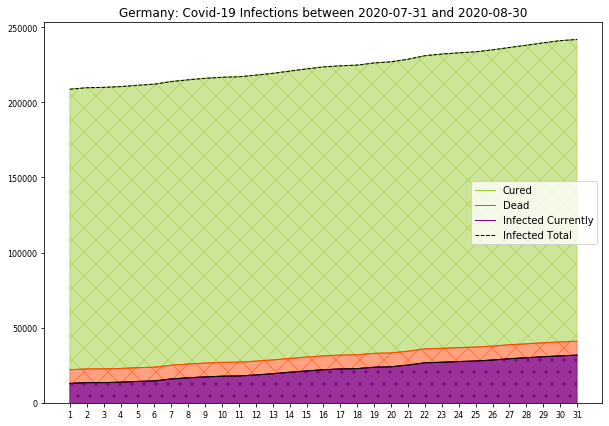

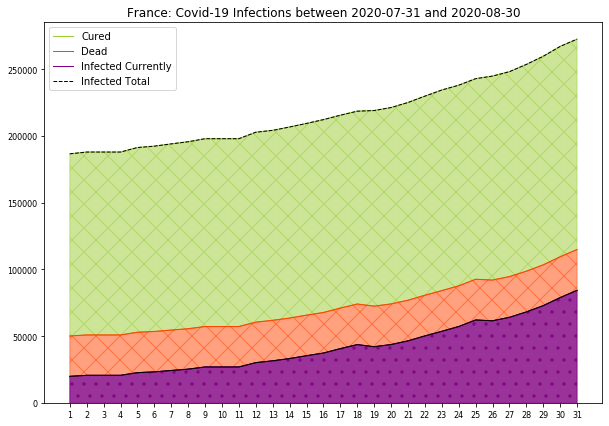

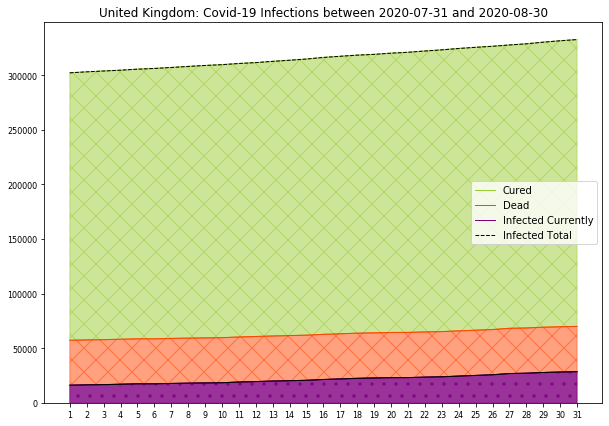

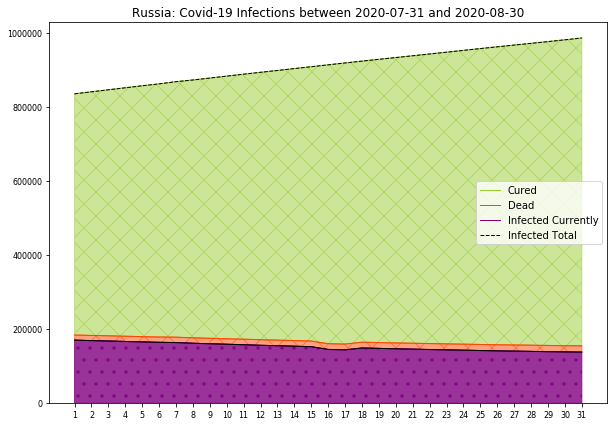

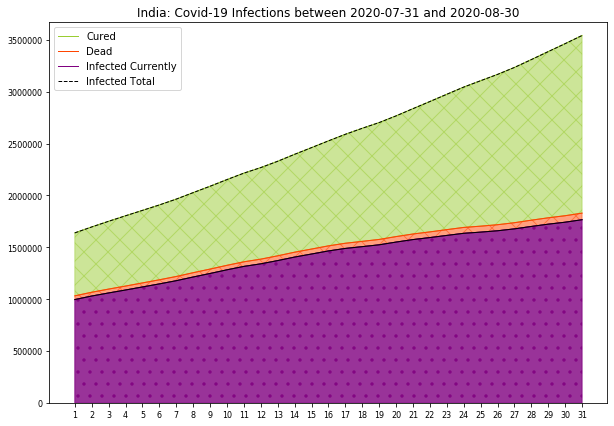

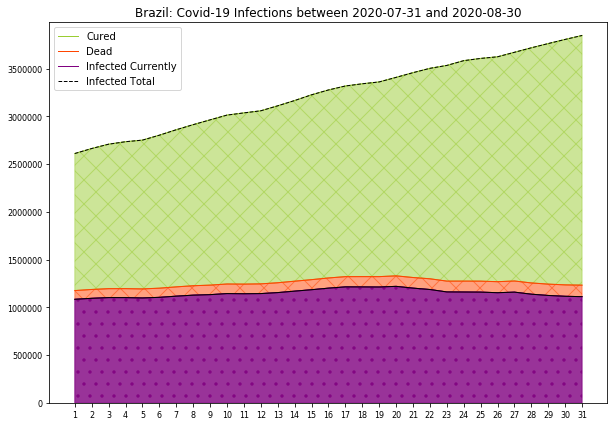

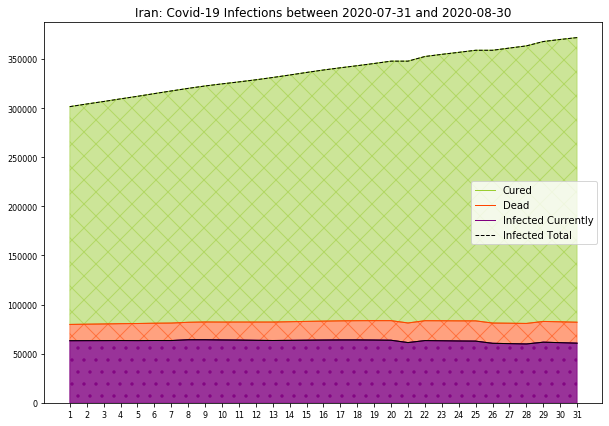

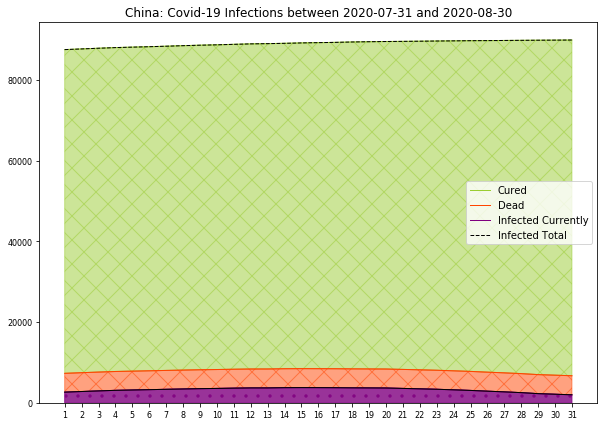

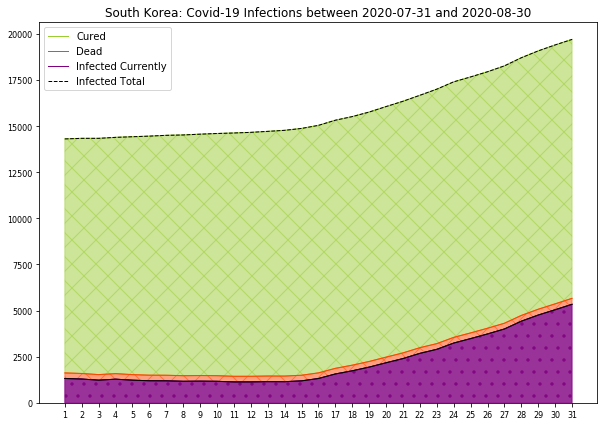

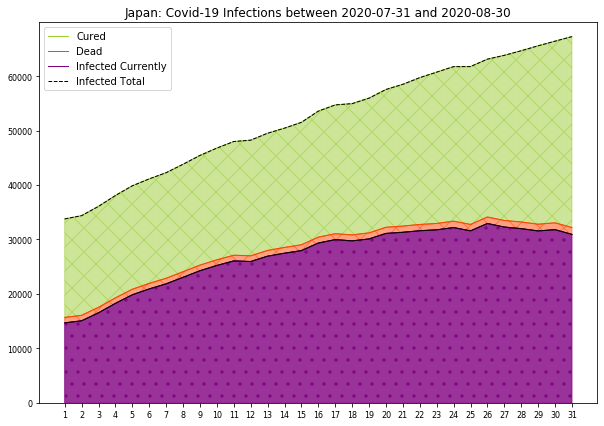

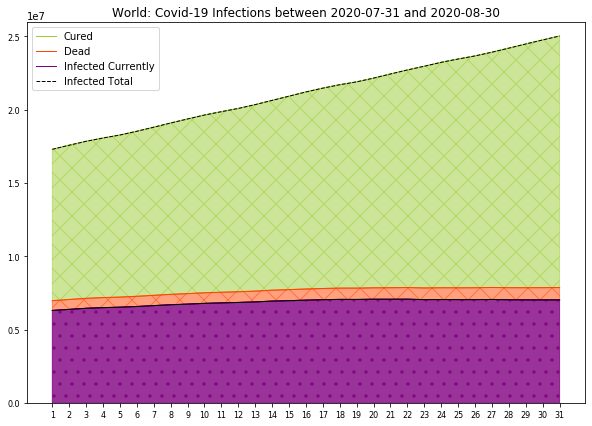

In [9]:
#visualize country

def plotCountryData(n = 14, location = 'Germany'):
    g = t2[t2.location == location][-n:].reset_index()
    #print(g.location[0] + ':\n')
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,6))
    x = range(1,n+1)
    ax1.set_yscale('linear')
    ax2.set_yscale('linear')
    ax1.yaxis.set_major_formatter(ScalarFormatter())
    ax2.yaxis.set_major_formatter(ScalarFormatter())
    ax1.set_xticks(x)
    ax1.tick_params(axis='both', which='major', labelsize=8)
    ax2.set_xticks(x)
    ax2.tick_params(axis='both', which='major', labelsize=8)
    ax1.set_title(location + ': Covid-19 Infections')
    ax2.set_title(location + ': Course of Disease')
    ax1.plot(x,g.total_cases,label='Total Cases',color='grey',lw=2)
    ax1.plot(x,g.currently_infected,label='Currently Infected',color='purple',lw=2)
    ax2.plot(x,g.cured,label='Cured',color='lime',lw=2)
    ax2.plot(x,g.total_deaths,label='Dead',color='crimson',lw=2)
    ax1.legend()
    ax2.legend()

# last n days of data and offset of days back in time
# n = time frame in last n days from today (or last data entry found)
# location = country name
# offset = move time frame x days into the past
# compareLimit = if plot borders are adjusted to worst case world wide (for visual comparison)
# <>size = dimensions the plot is drawn with
def plotCountryDataOne(n = 14, location = 'Germany', offset = 0, compareLimit = True, xsize=10, ysize=7):
    g = t2[t2.location == location][-n-offset:][:n].reset_index()
    #print(g.location[0] + ':\n')
    fig, ax = plt.subplots(figsize=(xsize,ysize))
    x = range(1,n+1)
    
    #ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.set_xticks(x)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_title(location + ': Covid-19 Infections between ' + g.date[0] + ' and ' + g.date[len(x)-1])
    
    ax.plot(x,g.total_cases,label='Cured',color='yellowgreen',lw=1)
    ax.plot(x,g.currently_infected + g.total_deaths,label='Dead',color='orangered',lw=1)
    ax.plot(x,g.currently_infected,label='Infected Currently',color='purple',lw=1)
    
    ax.fill_between(x, g.total_cases, g.currently_infected + g.total_deaths, color='yellowgreen', alpha=0.5, hatch='\\/')
    ax.fill_between(x, g.currently_infected + g.total_deaths, g.currently_infected, color='orangered', alpha=0.5, hatch='\\/')
    if compareLimit:
        ax.set_ylim([0,max(t2.total_cases[t2.location != 'World'])])
        ax.fill_between(x, 0, g.currently_infected, color='purple', alpha=0.8, hatch='.')
    else:
        ax.set_ylim(ymin = 0)
        ax.fill_between(x, 0, g.currently_infected, color='purple', alpha=0.8, hatch='.')
        #ax.fill_between(x, min(g.currently_infected), g.currently_infected, color='purple', alpha=0.8, hatch='.')
    
    ax.plot(x,g.total_cases,'--',label='Infected Total',color='black',lw=1)
    ax.plot(x,g.currently_infected,color='black',lw=1)
    
    ax.legend()
    

plotCountryDataOne(days,'United States',0,False)
plotCountryDataOne(days,'Italy',0,False)
plotCountryDataOne(days,'Spain',0,False)
plotCountryDataOne(days,'Germany',0,False)
plotCountryDataOne(days,'France',0,False)
plotCountryDataOne(days,'United Kingdom',0,False)
plotCountryDataOne(days,'Russia',0,False)
plotCountryDataOne(days,'India',0,False)
plotCountryDataOne(days,'Brazil',0,False)
plotCountryDataOne(days,'Iran',0,False)
plotCountryDataOne(days,'China',0,False)
plotCountryDataOne(days,'South Korea',0,False)
plotCountryDataOne(days,'Japan',0,False)
plotCountryDataOne(days,'World',0,False)


In [10]:
# Africa ?
#plotCountryDataOne(14,'Egypt',0,False,8,4)
#plotCountryDataOne(14,'Algeria',0,False,8,4)
#plotCountryDataOne(14,'South Africa',0,False,8,4)
#plotCountryDataOne(14,'Qatar',0,False,8,4)

In [11]:
# setup visualization
# DEFINE h for above which cases count a country is colored black!

# what data is shown on the map? <- set it
# see the @... in the hover = ... line
#d = 'currently_infected'
d = 'new_cases'

# what is the upper border of the scale? (painted black)
# standard setting: worst case of d in all countries
h = max(cdata[d][cdata.location != 'World'])

cmap = LinearColorMapper(palette = palette, low = 0, high = h, nan_color = '#DCDCDC')
cbar = ColorBar(color_mapper = cmap, label_standoff = 9, width = 500, height = 20, border_line_color = None, location = (0,0), orientation = 'horizontal')

def plot_map(geosource, name):
    name = 'Current World Wide Corona Infections ' + name
    hover = HoverTool(tooltips = [ ('Region','@country'),('total cases', '@total_cases'), ('total deaths', '@total_deaths'), ('new cases', '@new_cases'), ('new deaths', '@new_deaths'), ('cured', '@cured'), ('currently infected', '@currently_infected'), ('infected population', '@percent_infected')])
    fig = figure(title = name, plot_height = 500, plot_width = 800, background_fill_color = '#88C4FE', tools = [hover, 'pan', 'wheel_zoom'], x_range=(-30, 110), y_range=(20, 80))
    fig.xgrid.grid_line_color = None
    fig.ygrid.grid_line_color = None
    fig.patches('xs', 'ys', source = geosource, fill_color = {'field' : d, 'transform' : cmap}, line_color = 'black', line_width = 0.2, fill_alpha = 1)
    fig.add_layout(cbar, 'below')
    output_notebook() # jupyter notebook inline
    show(fig)

In [12]:
# show last n days
def show_recent(n):
    if (n == 'all'):
        n = len(dates)
    if (n > len(dates)): 
        print('No data for a time frame of', n, 'days!')
        return
    for i in range(n):
        date = str(dates[len(dates) - n + i])[:-9]
        src = GeoJSONDataSource(geojson = json_data(date))
        plot_map(src, date)

---

In [13]:
show_recent(3)

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

---

In [14]:
def plot_new_cases(n, region, smoothness = 13):
    
    if smoothness % 2 == 0:
        smoothness += 1
    
    data = cdata[cdata['location'] == region]
    data = data.reset_index()

    fig, (axcn, axdn) = plt.subplots(1, 2, figsize = (10,5))
    
    new = [int(dd) for dd in data['new_cases']][-n:]
    n = len(new)
    diffnew = [0] * (len(new))
    for i in range(1,len(new)-1):
        diffnew[i] = new[i+1] - new[i]
    
    avg = int(np.mean(diffnew))
    
    print('\033[1m' + region + '\033[0m' + ' had its peak at ' + str(max(new)) + ' new infections on a single day and')
    if avg < -1: # green text
        print('\033[92m' + 'an average decline of ' + str(avg) + ' new infections in the last ' + str(n) + ' days.')
    elif avg < 2: # blue text
        print('\033[94m' + 'no new infections in the last ' + str(n) + ' days (average).')
    else: # red text
        print('\033[91m' + str(avg) + ' new infections on average in the last ' + str(n) + ' days.')
    
    cases_subplot(axcn, new, n, 'daily new infections', smoothness)
    cases_subplot(axdn, diffnew, n, 'difference: below 0 = decline', smoothness)
    
    fig.subplots_adjust(right = 1.5)
    
    plt.show()

def subdiv_data(data,steps = 4):
    data_divided = [0] * (len(data))*(steps)
    for i in range(len(data)-1):
        index = i*steps
        data_divided[index] = data[i]
        diff = data[i+1] - data[i]
        for j in range(1,steps):
            weight = j / steps
            #data_divided[index+j] = (data[i] * weight + data[i+1] * (1-weight))
            data_divided[index+j] = data[i] + weight * diff
    data_divided[(len(data)-1)*steps] = data[len(data)-1]
    #nextp = 2*data[len(data)-1] - data[len(data)-2]
    for j in range(1,steps):
        #weight = j / steps
        data_divided[(len(data)-1)*steps + j] = data[len(data)-1] #+ nextp*weight
    return data_divided

def cases_subplot(ax, data, n, title, smoothness):
    s = 4
    x = range(n*s)
    y = data
    y = subdiv_data(y,s)
    yhat = savgol_filter(y, smoothness, 3)
    yavg = savgol_filter(y, n*2+1, 1)
    ax.set_title(title)
    ax.set_xticks([])
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlabel('last ' + str(n) + ' days')
    ax.set_ylim([min(0,min(y)),max(y) + int(max(y)/10)])
    ax.set_xlim([0,n*s])
    #ax.plot(x,y)
    ax.plot(x,yhat)
    ax.plot(x,yavg,'--',lw=0.5,color='cyan')
    ax.plot([0,n*s],[0,0],'--',lw=1,color = 'gray')
    # uncomment for accurate data as points
    #x2 = np.arange(0,n*s,s)
    #ax.plot(x2,data,'or',color='gray',ms=2)



Today is 2020-08-30

Zoom in on Germany

Germany had its peak at 6294 new infections on a single day and
3 new infections on average in the last 200 days.


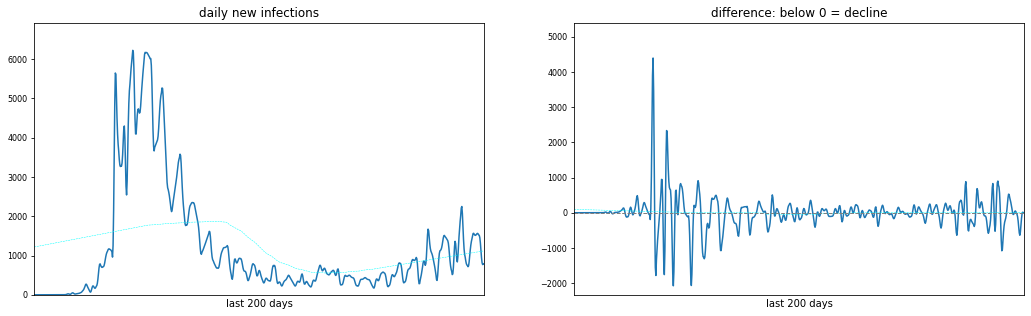

Germany had its peak at 2327 new infections on a single day and
5 new infections on average in the last 60 days.


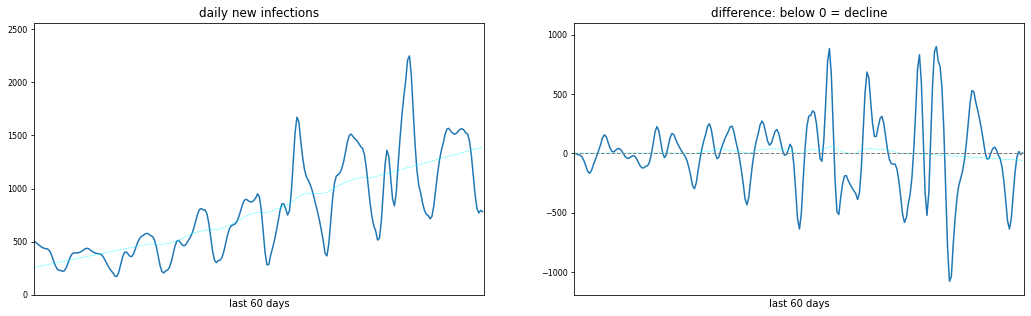

Germany had its peak at 2327 new infections on a single day and
an average decline of -46 new infections in the last 14 days.


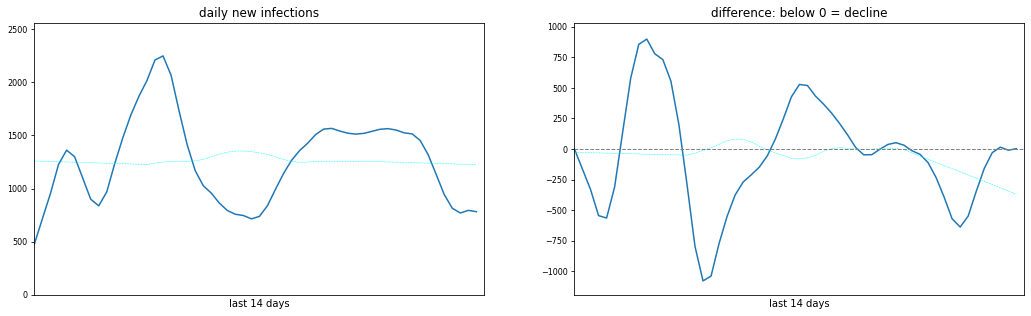



---------------------------------------------------------------------
last 60 days in other countries
---------------------------------------------------------------------


Brazil had its peak at 69074 new infections on a single day and
an average decline of -112 new infections in the last 60 days.


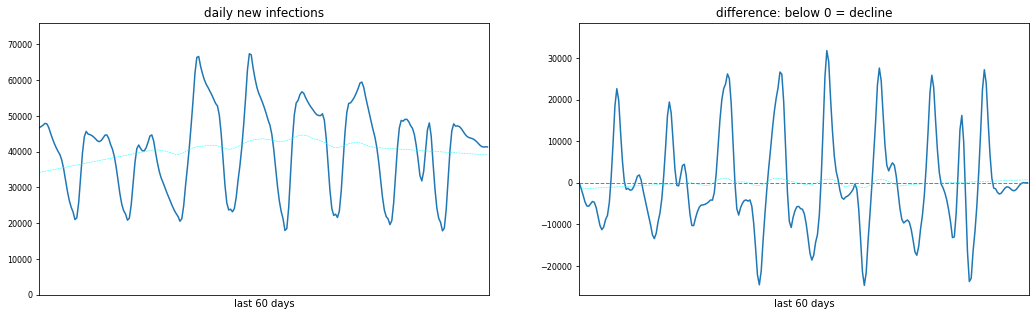

India had its peak at 78761 new infections on a single day and
964 new infections on average in the last 60 days.


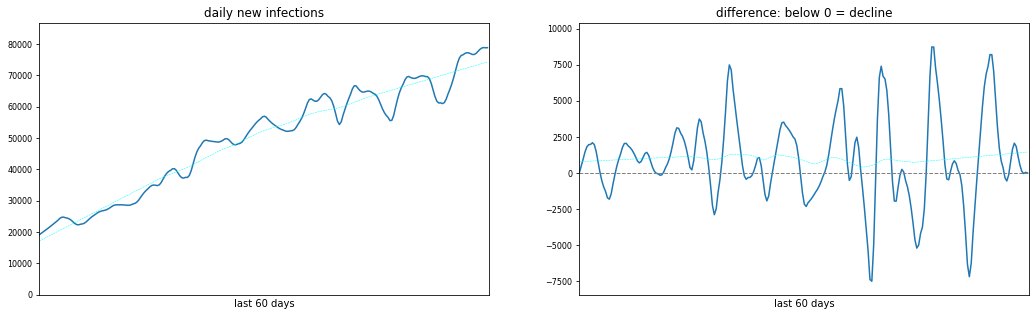

China had its peak at 276 new infections on a single day and
no new infections in the last 60 days (average).


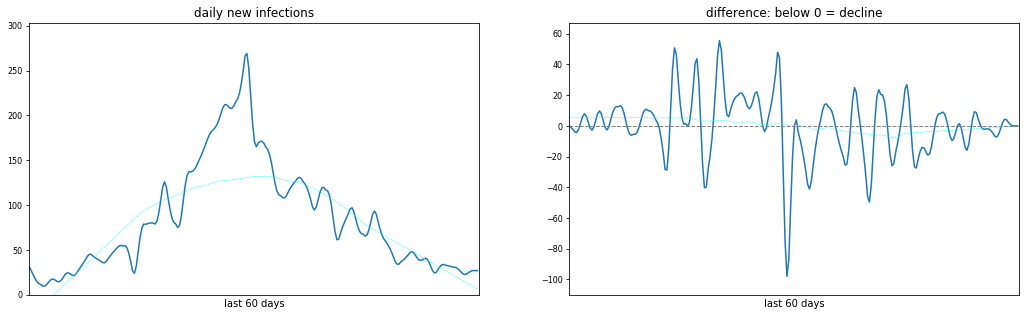

United States had its peak at 78427 new infections on a single day and
an average decline of -154 new infections in the last 60 days.


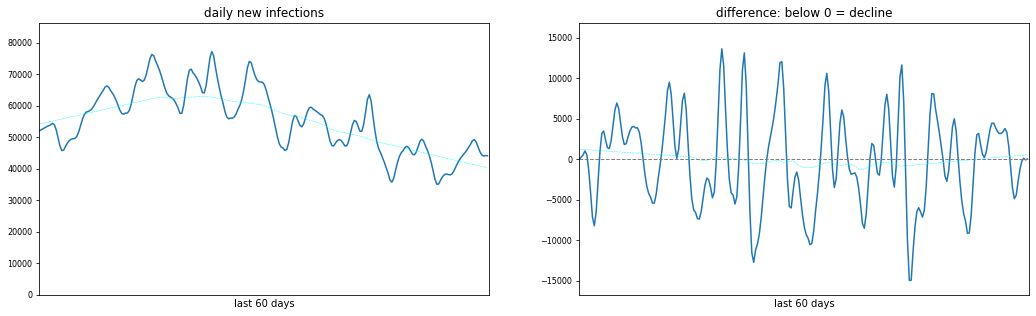

South Africa had its peak at 13944 new infections on a single day and
an average decline of -105 new infections in the last 60 days.


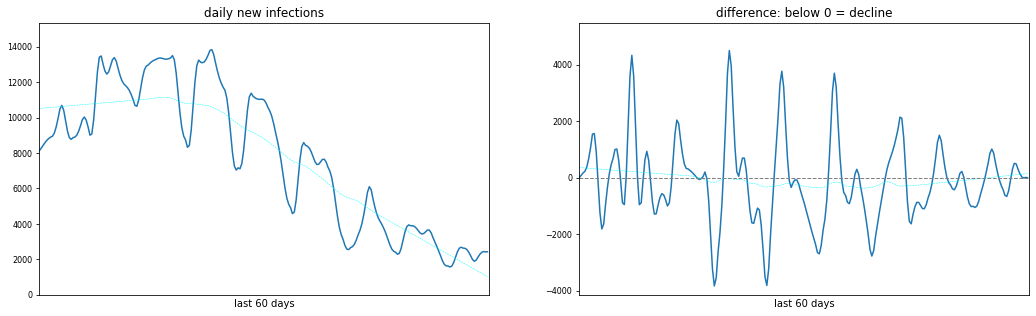

Spain had its peak at 19382 new infections on a single day and
an average decline of -7 new infections in the last 60 days.


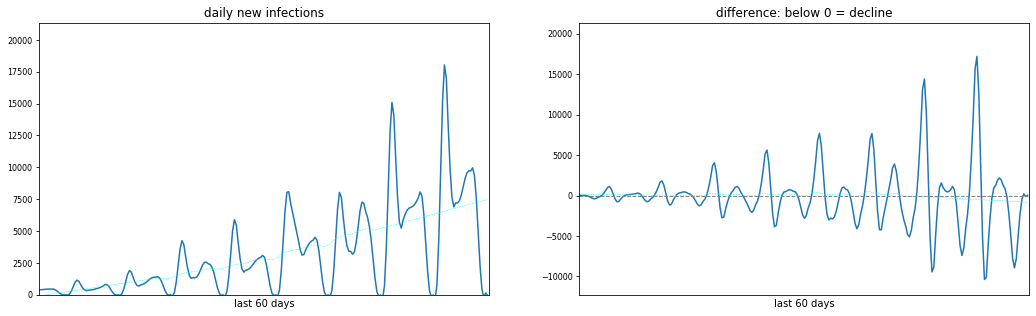

In [15]:
n = 60 # last n days
s = 5 # smoothness of the curve s - bigger is smooth, 5 is most accurate, smaller 5 is illegal

print('\n\033[1mToday is ' + str(dates[-1])[:-9] + '\n\033[4m\nZoom in on Germany\n\033[0m')
plot_new_cases(200,'Germany',s)
plot_new_cases(60,'Germany',s)
plot_new_cases(14,'Germany',s)
print('\n\n---------------------------------------------------------------------\nlast 60 days in other countries\n---------------------------------------------------------------------\n\n')
plot_new_cases(n,'Brazil',s)
plot_new_cases(n,'India',s)
plot_new_cases(n,'China',s)
plot_new_cases(n,'United States',s)
plot_new_cases(n,'South Africa',s)
plot_new_cases(n,'Spain',s)